In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
import copy
import os
import pprint

import hydra
from omegaconf import OmegaConf
from einops import rearrange
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlalchemy as sa
import marimo as mo
import seaborn as sns
import lightning.pytorch
import polars as pl
from tqdm import tqdm

from conf import conf
from dafm import datasets, models, plots, utils

In [3]:
with hydra.initialize(version_base=utils.HYDRA_INIT['version_base'], config_path='../conf'):
    cfg = hydra.compose(utils.HYDRA_INIT['config_name'], overrides=[
        'model=ScoreMatchingMarginalBao2024EnSF',
        'dataset=KuramotoSivashinsky',
    ])
    engine = conf.get_engine()
    conf.orm.create_all(engine)
    with conf.sa.orm.Session(engine) as db:
        cfg = conf.orm.instantiate_and_insert_config(db, OmegaConf.to_container(cfg, resolve=True))
        pprint.pp(cfg.dataset)

KuramotoSivashinsky(trajectory_stored_on_gpu_max_state_dimension=200000,
                    save_data_every_n_time_steps=None,
                    state_dimension=1024,
                    model_noise_std=0.0,
                    observation_noise_std=0.1,
                    predicted_state_initial_condition_add_true_state=True,
                    predicted_state_initial_condition_std=1.0,
                    predicted_state_model_noise_std=0.0,
                    predicted_state_count=20,
                    time_step_count=6000,
                    time_step_count_drop_first=2000,
                    time_step_size=0.25,
                    observe_every_n_time_steps=4,
                    observe=ATan(id=1),
                    integrator=<Integrator.RUNGE_KUTTA_4: 1>,
                    state_perturbation=<StatePerturbation.IDENTITY: 1>,
                    use_predicted_state_perturbation=False,
                    predicted_state_perturbation_std=0.0,
                    id=

In [119]:
dynamics = datasets.get_dynamics_dataset(cfg.dataset, np.random.default_rng(utils.RNG_RANDBITS[cfg.rng_seed]), 'cpu')

In [120]:
# initial_condition = dynamics.true_state
data_list = [dynamics.true_state, *(dynamics.true_state for _ in dynamics)]

In [121]:
len(data_list)

4001

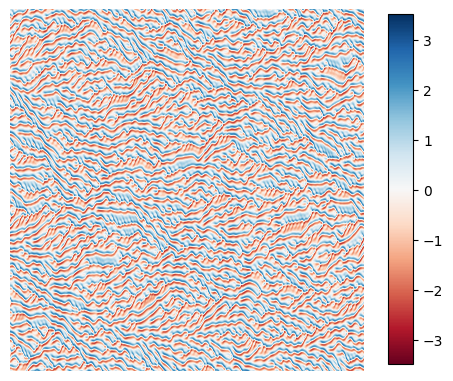

In [122]:
data = rearrange(
    data_list,
    'time_step_count 1 dim -> dim time_step_count',
)[:, 1::cfg.dataset.observe_every_n_time_steps].numpy()
g = sns.FacetGrid(
    data=pd.DataFrame({0: [0]}, index=[0]),
    height=5,
)
for (row, col, hue), _ in g.facet_data():
    ax = g.axes[row][col]
    ax.set_axis_off()
    im_out = ax.imshow(data, cmap='RdBu', vmin=data.min(), vmax=data.max())
g.figure.subplots_adjust(right=.8)
cbar_ax = g.figure.add_axes([0.85, 0.17, 0.05, 0.7])
g.figure.colorbar(im_out, cax=cbar_ax)